<a href="https://colab.research.google.com/github/Drfengze/MultiObjectiveOptimization/blob/master/griddataXarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [3]:
!conda install esmpy
!conda install xesmf dask
!apt-get -qq install python-cartopy python3-cartopy

Solving environment: / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - esmpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.24  |                0         125 KB
    certifi-2020.6.20          |           py37_0         156 KB
    ------------------------------------------------------------
                                           Total:         281 KB

The following packages will be UPDATED:

  ca-certificates                                2020.1.1-0 --> 2020.6.24-0
  certifi                                 2020.4.5.1-py37_0 --> 2020.6.20-py37_0


Proceed ([y]/n)? y


ca-certificates-2020 | 125 KB    | : 100% 1.0/1 [00:00<00:00,  9.50it/s]
certifi-2020.6.20    | 156 KB    | : 100% 1.0/1 [00:00<00:00, 19.45it/s]
Preparing transaction: | done
Verifying transaction: - done
Executing transact

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/My Drive/data.csv')

In [7]:
lat = xr.DataArray(np.reshape(df.lat.values,[201,161]),dims = ['x','y'])
lon = xr.DataArray(np.reshape(df.lon.values,[201,161]),dims = ['x','y'])
lat

<xarray.DataArray (x: 201, y: 161)>
array([[37.5004 , 37.50135, 37.5023 , ..., 37.50135, 37.5004 , 37.49944],
       [37.52806, 37.52901, 37.52995, ..., 37.52901, 37.52806, 37.5271 ],
       [37.55572, 37.55667, 37.55761, ..., 37.55667, 37.55572, 37.55475],
       ...,
       [43.00354, 43.0046 , 43.00563, ..., 43.0046 , 43.00354, 43.00248],
       [43.03144, 43.03249, 43.03353, ..., 43.03249, 43.03144, 43.03037],
       [43.05933, 43.06039, 43.06142, ..., 43.06039, 43.05933, 43.05827]])
Dimensions without coordinates: x, y

In [8]:
T = xr.DataArray(df.drop(["Unnamed: 0",'lat','lon'],axis=1).values.reshape([-1,201,161]),dims=['time','x','y'])
DS = xr.Dataset({'T':T},coords={'lat':lat,'lon':lon,'time':df.drop(["Unnamed: 0",'lat','lon'],axis=1).columns})

In [9]:
DS

<xarray.Dataset>
Dimensions:  (time: 31, x: 201, y: 161)
Coordinates:
    lat      (x, y) float64 37.5 37.5 37.5 37.5 37.5 ... 43.06 43.06 43.06 43.06
    lon      (x, y) float64 96.73 96.76 96.8 96.83 ... 102.5 102.5 102.5 102.6
  * time     (time) object '2011-01-01 00:00:00' ... '2011-01-31 00:00:00'
Dimensions without coordinates: x, y
Data variables:
    T        (time, x, y) float64 263.2 263.0 263.2 263.2 ... 265.6 265.8 266.1

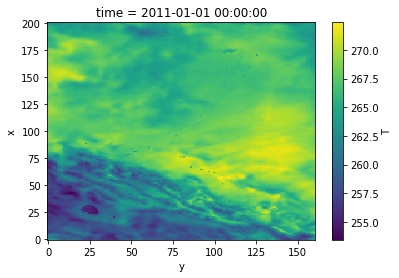

In [10]:
DS.T.isel(time=0).plot()

Text(0, 0.5, 'lat')

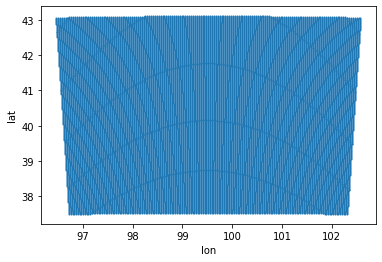

In [12]:
plt.scatter(DS['lon'], DS['lat'], s=1)  # plot grid locations
# plt.ylim([30, 45])
plt.xlabel('lon')
plt.ylabel('lat')

In [13]:
# grid = xe.util.grid_2d(np.min(lon.values), np.max(lon.values),0.005, np.min(lat.values), np.max(lat.values),0.005)

In [27]:
DS_out = xr.Dataset({'lat': (['lat'], np.arange(np.min(lat.values), np.max(lat.values),0.005)),
                     'lon': (['lon'], np.arange(np.min(lon.values), np.max(lon.values),0.005)),
                    }
                   )

regridder = xe.Regridder(DS, DS_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_201x161_1121x1223.nc
Remove file bilinear_201x161_1121x1223.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_201x161_1121x1223.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 161) 
Output grid shape:          (1121, 1223) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [28]:
DS_out = regridder(DS)
DS_out

using dimensions ('x', 'y') from data variable T as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (lat: 1121, lon: 1223, time: 31)
Coordinates:
  * time     (time) object '2011-01-01 00:00:00' ... '2011-01-31 00:00:00'
  * lon      (lon) float64 96.46 96.47 96.47 96.48 ... 102.6 102.6 102.6 102.6
  * lat      (lat) float64 37.5 37.5 37.51 37.51 ... 43.08 43.09 43.09 43.1
Data variables:
    T        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [25]:
DS_out =  regridder(DS)
regridder.clean_weight_file()

using dimensions ('x', 'y') from data variable T as the horizontal dimensions for this dataset.
Remove file bilinear_201x161_1121x1223.nc


In [18]:
DS_out

<xarray.Dataset>
Dimensions:  (time: 31, x: 1223, y: 1121)
Coordinates:
  * time     (time) object '2011-01-01 00:00:00' ... '2011-01-31 00:00:00'
    lon      (y, x) float64 96.46 96.47 96.47 96.48 ... 102.6 102.6 102.6 102.6
    lat      (y, x) float64 37.5 37.5 37.5 37.5 37.5 ... 43.1 43.1 43.1 43.1
Dimensions without coordinates: x, y
Data variables:
    T        (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

Text(0, 0.5, 'lat')

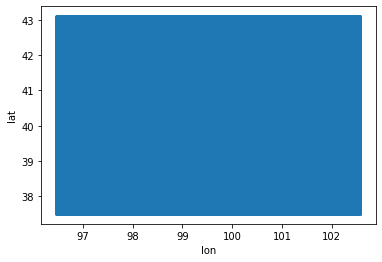

In [20]:
plt.scatter(DS_out['lon'], DS_out['lat'], s=1)  # plot grid locations
# plt.ylim([30, 45])
plt.xlabel('lon')
plt.ylabel('lat')

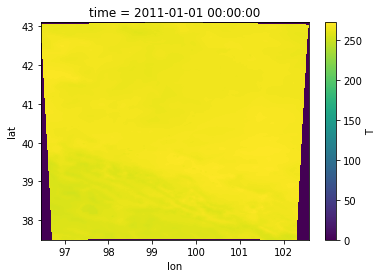

In [29]:
DS_out.T.isel(time=0).plot()